In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as itertools
from scipy.fft import fft, fftfreq
from copy import deepcopy 

In [2]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import hypyp
from hypyp.signal import SynteticSignal
from hypyp.plots import (
    spectrogram_plot,
    spectrogram_plot_period,
    plot_coifs,
    plot_im,
    plot_im_diff,
    plot_line,
    plot_S12,
    plot_times,
    plot_spectrogram_periods
)
from hypyp.fnirs_tools import (
    xwt_coherence_morl,
)
from hypyp.fnirs_tools_orig import (
    xwt_coherence_morl_orig
)

import pywt
import pycwt


Loading pwt from /home/patrice/work/ppsp/pywt/pywt


ninja: error: '/tmp/pip-build-env-tiw5qk87/overlay/bin/cython', needed by 'pywt/_extensions/_cwt.cpython-311-x86_64-linux-gnu.so.p/_cwt.c', missing and no known rule to make it


## Load snirfs

In [3]:
fname1 = '../data/sub-110_session-1_pre_raw.fif'
fname2 = '../data/sub-110_session-1_pre_raw.fif'

chs1 = ["S4_D4 hbo"] 
chs2 = ["S7_D6 hbo"]

#set events
tmin = 0 
tmax = 300
baseline = (0, 0)

from hypyp.fnirs import Subject, DyadFNIRS

dyad = DyadFNIRS(
    Subject().load_snirf_file(fname1).set_best_ch_names(chs1),
    Subject().load_snirf_file(fname2).set_best_ch_names(chs2)
).load_epochs(tmin, tmax, baseline)




Opening raw data file ../data/sub-110_session-1_pre_raw.fif...
    Range : 0 ... 5579 =      0.000 ...  1115.800 secs
Ready.
Reading 0 ... 5579  =      0.000 ...  1115.800 secs...
Opening raw data file ../data/sub-110_session-1_pre_raw.fif...
    Range : 0 ... 5579 =      0.000 ...  1115.800 secs
Ready.
Reading 0 ... 5579  =      0.000 ...  1115.800 secs...
Used Annotations descriptions: ['1', '2', '3', '4']
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['1', '2', '3', '4']
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


## Sine waves

Using data from preloaded Raw for 4 events and 1501 original time points ...
1 bad epochs dropped


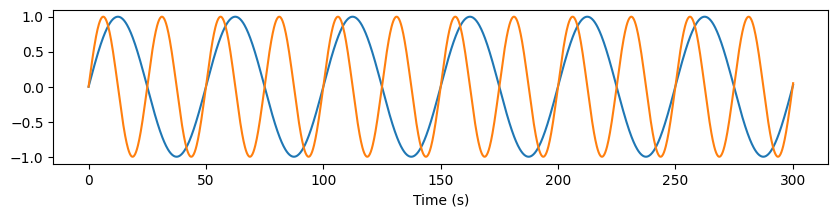

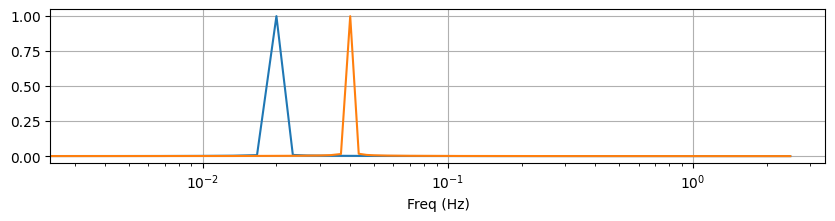

In [4]:

# take N from real data
N = len(dyad.s1.epochs.get_data()[0,0,:]) # N = 1501
sfreq = dyad.s1.epochs.info['sfreq'] # 5.0
period = 1 / sfreq
signal_freqs = [0.02, 0.04]
#signal_freqs = [1/50, 1/25]

signals = [SynteticSignal(tmax=N/sfreq, n_points=N).gen_sin(signal_freq) for signal_freq in signal_freqs]

plt.figure(figsize=(10, 2))
[sig.plot() for sig in signals]
plt.show()

plt.figure(figsize=(10,2))
[sig.plot_fft() for sig in signals]
plt.grid()
plt.show()


## CWT
Continuous Wavelet Transform

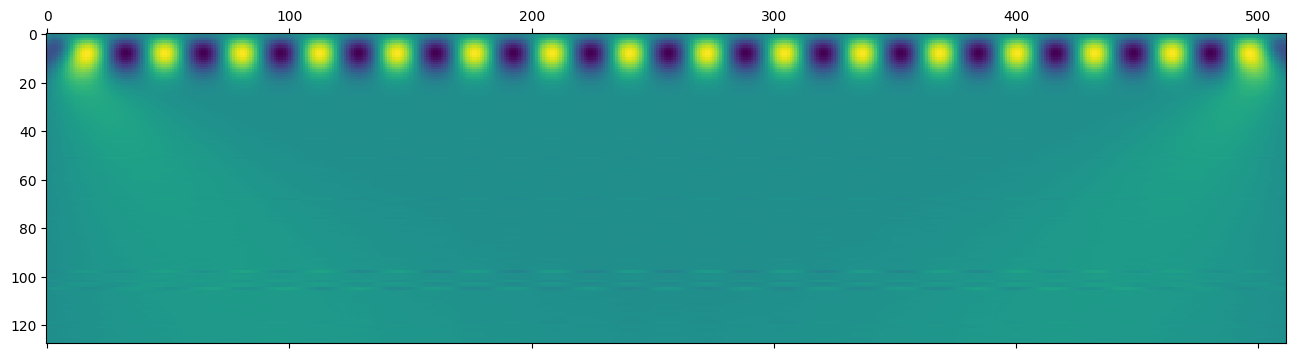

In [5]:
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef)
plt.show()

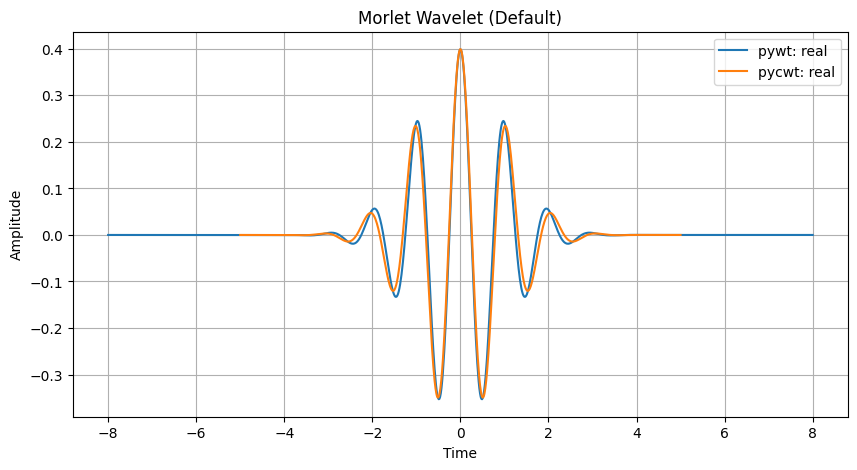

In [17]:
# pycwt.cwt
# Define the range of time values

[psi_pywt, x_pwtw] = pywt.ContinuousWavelet('cmor2, 1').wavefun(10)

morlet_wavelet_pycwt = pycwt.wavelet.Morlet()

# Calculate the wavelet values
t_pycwt = np.linspace(-5, 5, 1000)
wavelet_values_pycwt = morlet_wavelet_pycwt.psi(t_pycwt)

# Plot the wavelet
plt.figure(figsize=(10, 5))
plt.plot(x_pwtw, np.real(psi_pywt), label="pywt: real")
#plt.plot(x, np.imag(psi_pywt), label="pywt: imag")
plt.plot(t_pycwt, wavelet_values_pycwt.real, label='pycwt: real')
#plt.plot(t, wavelet_values.imag, label='pycwt: imag')
plt.title('Morlet Wavelet (Default)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()



<Figure size 640x480 with 0 Axes>

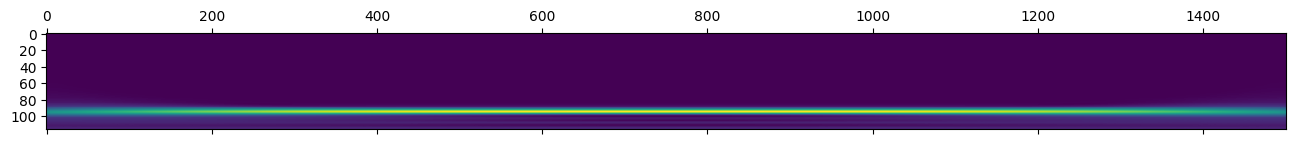

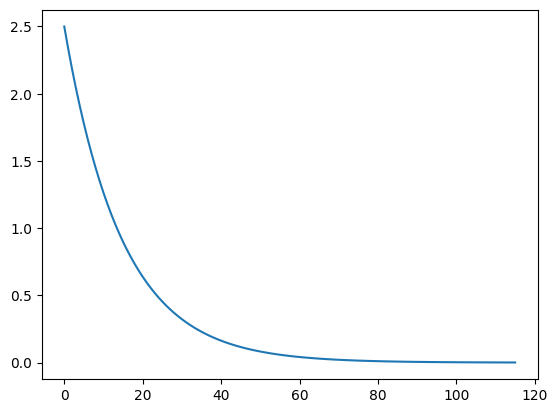

In [19]:
# pywt.cwt

widths = np.geomspace(1/2.5, 1024, num=116)
W_pywt, signal_freqs = pywt.cwt(
    SynteticSignal(tmax=N/sfreq, n_points=N).gen_sin(0.02).y,
    widths,
    #'gaus1'
    'cmor2, 1'
)

#plt.matshow(np.real(W))
#plt.show()
#plt.matshow(np.imag(W))
#plt.show()
plt.figure()
plt.matshow(np.abs(W_pywt))
plt.show()

plt.plot(signal_freqs) # 2.5 is half of our sampling rate



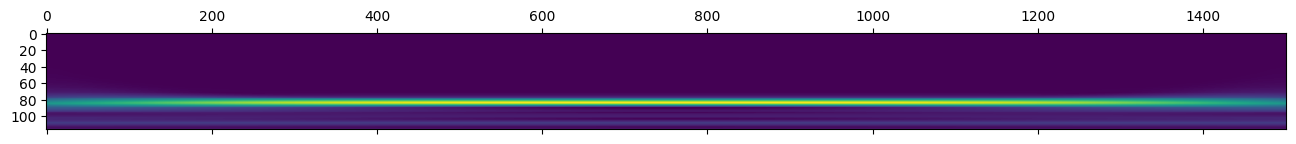

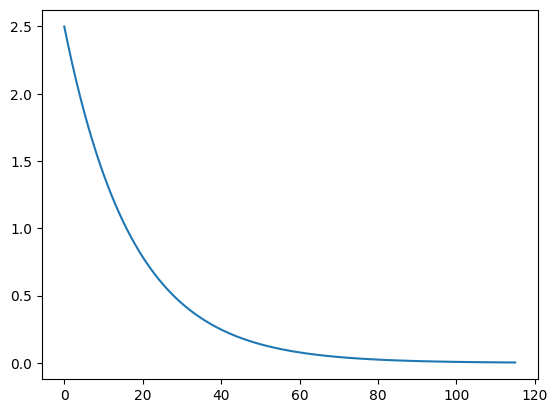

In [21]:


W_pycwt, sj, signal_freqs, coi, fft, fftfreqs = pycwt.cwt(
    SynteticSignal(tmax=N/sfreq, n_points=N).gen_sin(0.02).y,
    1/sfreq
)

#plt.matshow(np.real(W_pycwt))
#plt.show()
#plt.matshow(np.imag(W_pycwt))
#plt.show()
plt.matshow(np.abs(W_pycwt))
plt.show()

plt.plot(signal_freqs) # 2.5 is half of our sampling rate


<Figure size 640x480 with 0 Axes>

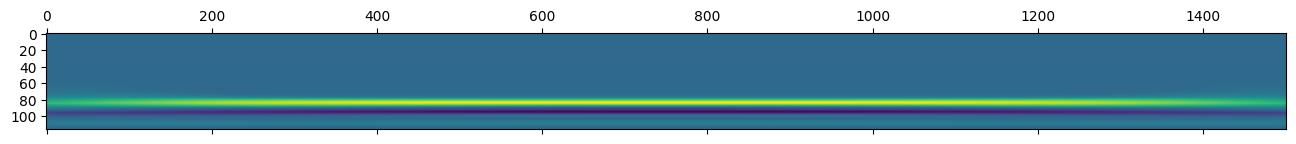

In [22]:
plt.figure()
plt.matshow(np.abs(W_pycwt) - np.abs(W_pywt))
plt.show()


## WCT

frequencies: (116,)
frequencies: (116,)


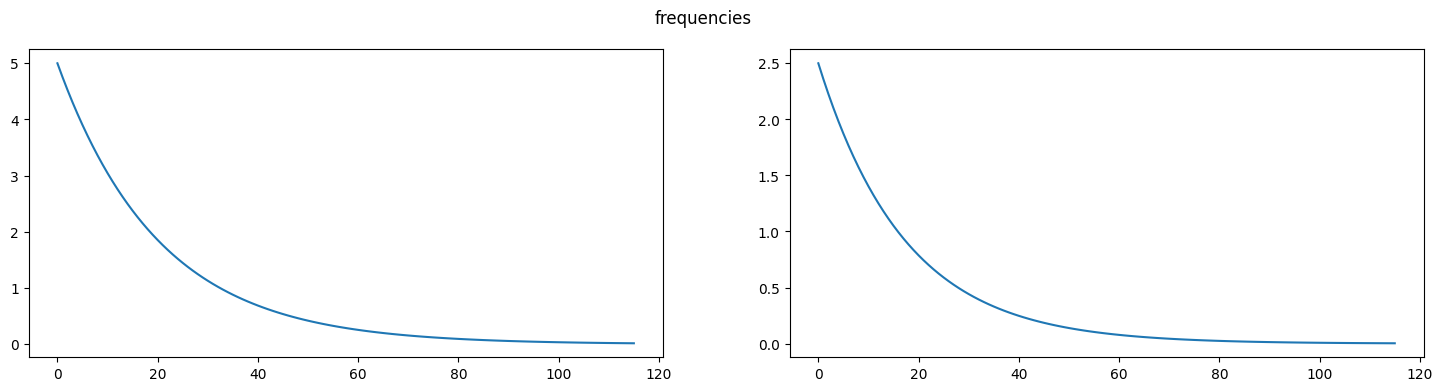

scales (sj): (116,)
scales (sj): (116,)


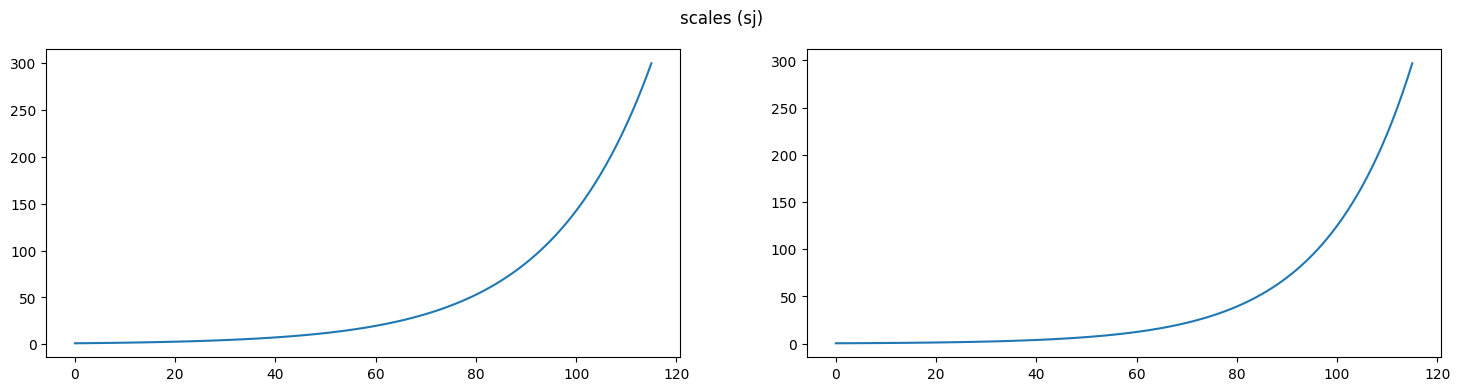

shape of wct: (116, 1501)
0.6848170611701581
shape of wct: (116, 1501)
0.11055957311802635


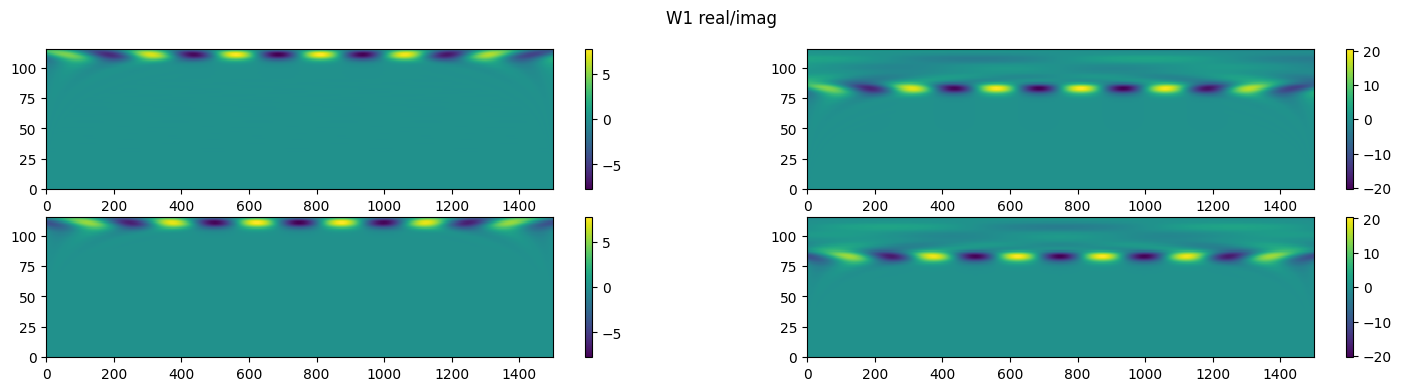

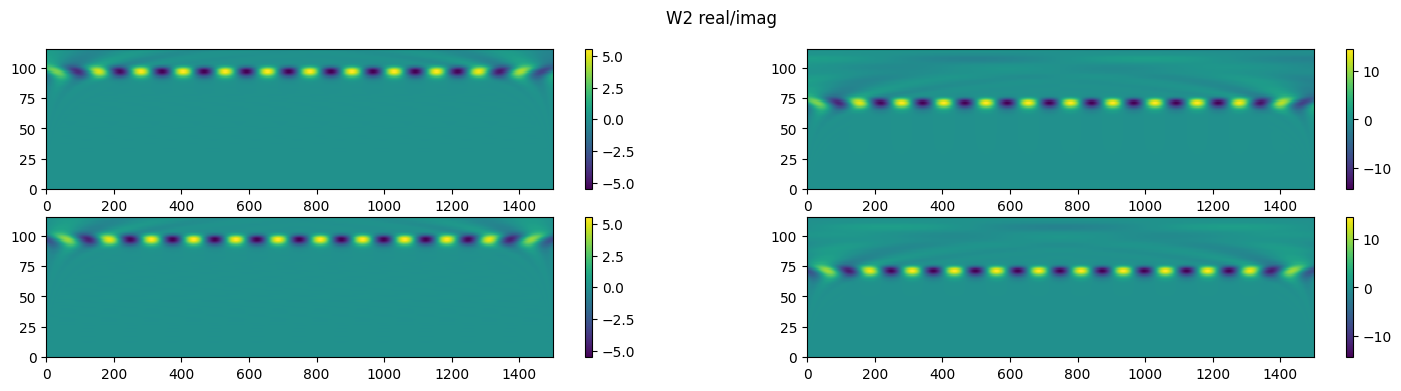

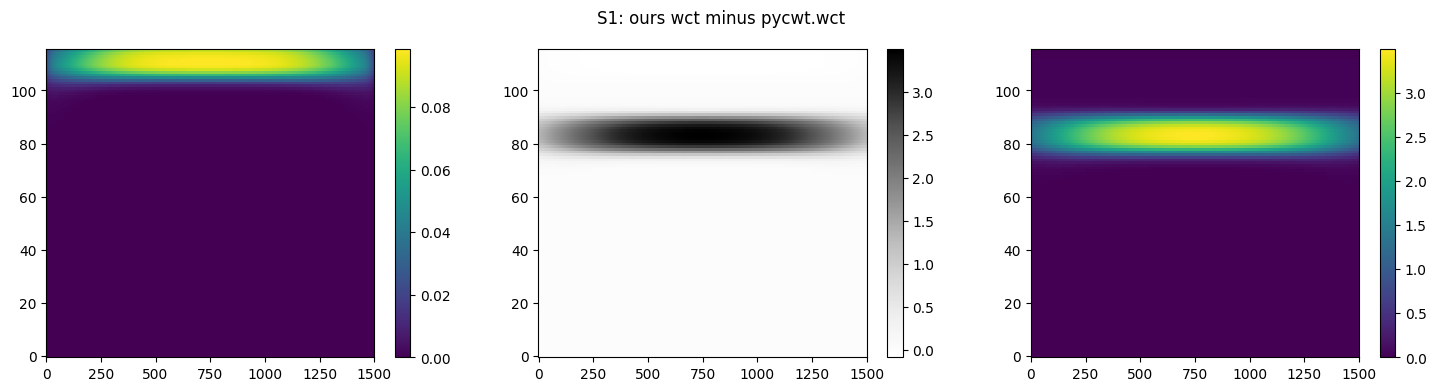

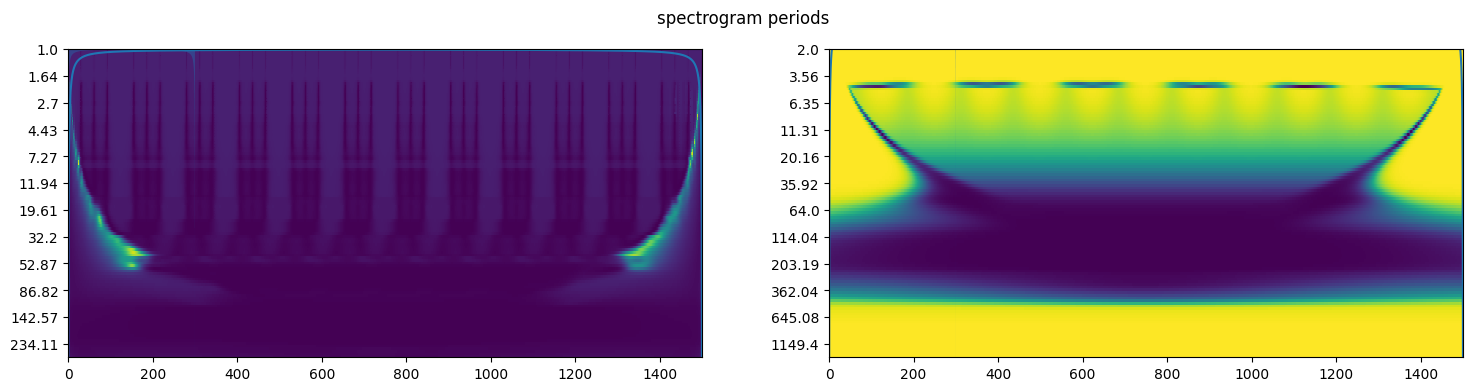

In [25]:
import matplotlib.cm as cm

items = []

#tracers = [dict() for _ in range(3)]
tracers = [dict() for _ in range(2)]

#wct_morlet = xwt_coherence_morl_orig(signals[0].y, signals[1].y, sample_rate, tracer=tracers[0])
#wct, times, freq, coif = deepcopy(wct_morlet)
#items.append(dict(
#    wct=wct,
#    times=times,
#    freq=freq,
#    coif=coif,
#))

wct_morlet = xwt_coherence_morl(signals[0].y, signals[1].y, sfreq, tracer=tracers[0])
wct, times, freq, coif = deepcopy(wct_morlet)
items.append(dict(
    wct=wct,
    times=times,
    freq=freq,
    coif=coif,
))

WCT, aWCT, coi, freq, sig = pycwt.wct(signals[0].y, signals[1].y, dt=1/5, sig=False, tracer=tracers[1])
items.append(dict(
    wct=WCT,
    times=times, # this does not come from pycwt.wct
    freq=freq,
    coif=coif,
))

plot_line(tracers, 'freq', 'frequencies')
#plot_im(tracers, 'S1')
#plot_im(tracers, 'S2')
#plot_S12(tracers)
plot_line(tracers, 'scales', 'scales (sj)')
plot_im(tracers, 'W1', 'W1 real/imag')
plot_im(tracers, 'W2', 'W2 real/imag')
plot_im_diff(tracers[0]['S1'], tracers[1]['S1'], 'S1: ours wct minus pycwt.wct')
#plot_im_diff(tracers[1]['S2'], tracers[2]['S2'], 'S2: ours wct minus pycwt.wct')
#plot_coifs(items)
#plot_times(items)
plot_spectrogram_periods(items)